In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch import Tensor

from preprocess import PTPSequenceParser as PTPparser
from coordinate import coordConverter
from PTPfunction import truncSeq
from PTPfunction import generate_mask
from PTPfunction import ADE
from torch.nn import TripletMarginLoss
from torch import optim

parser = PTPparser(filename="../dataset/ewap_dataset/seq_eth/obsmat.txt", 
                    homo_path="../dataset/ewap_dataset/seq_eth/H.txt",isMeter=False)

seq_length = 20
trainF, testF = parser.train_test_split(seq_size=seq_length)
trainPT, testPT = None, None
trainPT = truncSeq(trainF)
testPT = truncSeq(testF)

trainPT, testPT = trainPT[:,:,2:], testPT[:,:,2:]
train_src, train_tgt = torch.tensor(trainPT[:,0:seq_length//2,:]), torch.tensor(trainPT[:,seq_length//2:,:])
'''Train length of 10 and test 11 starting with end'''
train_src = train_src.to(torch.float32)
train_tgt = train_tgt.to(torch.float32)




In [53]:
def TripletSeqLoss(positive, negative, anchor, margin=1):
    z = 3*ADE(positive, anchor) + ADE(negative, anchor)**(-0.5)
    print(ADE(positive, anchor), ADE(negative, anchor))
    return z

In [36]:
from zenTransformer import zenTransformer
from Siamese import SiameseModel

#model = zenTransformer(d_model=4,nhead=4,num_decoder_layer=3,num_encoder_layer=3,dim_feedforward=4)
submodel = zenTransformer(d_input=2,d_model=128,nhead=8,num_decoder_layer=6,num_encoder_layer=6,dim_feedforward=2048)
basemodel = torch.load('./TransformerModel')
SiameseTransformer = SiameseModel(subtransformer=submodel)

In [55]:
SiameseTransformer.eval()
optimizer = optim.SGD(SiameseTransformer.parameters(), lr = 0.00001, momentum=0.99)
train_src = train_src[:,:,0:2]
train_tgt = train_tgt[:,:,0:2]
for epc in range(0,100):
    batch_size = 10
    total_loss = 0
    for batch in range(train_src.size(0)//batch_size):
        train_src_batch = train_src[batch_size*batch: batch_size*(batch+1)]
        train_tgt_batch = train_tgt[batch_size*batch: batch_size*(batch+1)]
        train_tgt_batch = torch.cat((
            train_src_batch[:,-1:,:], train_tgt_batch
            #torch.zeros((train_tgt_batch.size(0), 1, train_tgt_batch.size(2))), train_tgt_batch
        ),dim=1)
        '''tgt1 is positive and tgt2 is negative'''
        output1, output2 = SiameseTransformer(
                    train_src_batch, 
                    train_tgt_batch[:,:-1,:], 
                    basemodel.greedy_decode(train_src_batch, src_mask=generate_mask(seq_length//2), max_len=10),
                    src_mask = generate_mask(10), # torch.zeros((10,10))
                    tgt_mask=generate_mask(seq_length//2))
        optimizer.zero_grad()
        loss = TripletSeqLoss(output1, output2, train_tgt_batch[:,1:,:], margin=0.5)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() / (train_src.size(0)//batch_size)
        # for p in model.parameters():
        #     p.data.add_(p.grad, alpha=-0.01)
    print(f"Epoch:", epc)
    print("--Loss--:",total_loss)

tensor(0.1726, grad_fn=<MeanBackward0>) tensor(1.6024, grad_fn=<MeanBackward0>)
tensor(0.1792, grad_fn=<MeanBackward0>) tensor(1.5078, grad_fn=<MeanBackward0>)
tensor(0.1650, grad_fn=<MeanBackward0>) tensor(1.2960, grad_fn=<MeanBackward0>)
tensor(0.1379, grad_fn=<MeanBackward0>) tensor(1.3670, grad_fn=<MeanBackward0>)
tensor(0.1234, grad_fn=<MeanBackward0>) tensor(1.6988, grad_fn=<MeanBackward0>)
tensor(0.1319, grad_fn=<MeanBackward0>) tensor(1.3820, grad_fn=<MeanBackward0>)
tensor(0.1398, grad_fn=<MeanBackward0>) tensor(1.3223, grad_fn=<MeanBackward0>)
tensor(0.1144, grad_fn=<MeanBackward0>) tensor(1.6368, grad_fn=<MeanBackward0>)
tensor(0.1358, grad_fn=<MeanBackward0>) tensor(1.3816, grad_fn=<MeanBackward0>)
tensor(0.1711, grad_fn=<MeanBackward0>) tensor(1.6023, grad_fn=<MeanBackward0>)
tensor(0.1929, grad_fn=<MeanBackward0>) tensor(1.4456, grad_fn=<MeanBackward0>)
tensor(0.1738, grad_fn=<MeanBackward0>) tensor(1.2795, grad_fn=<MeanBackward0>)
tensor(0.1257, grad_fn=<MeanBackward0>) 

KeyboardInterrupt: 

The ADE on test set is: tensor(1.0967, grad_fn=<MeanBackward0>)
The FDE on test set is: tensor(3.1406, grad_fn=<MeanBackward0>)


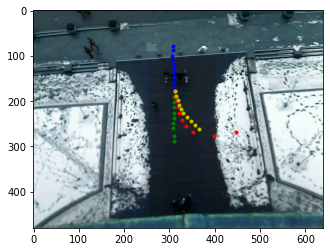

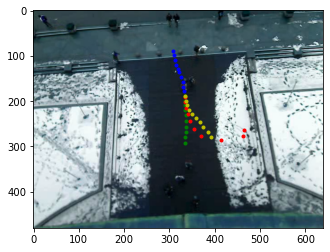

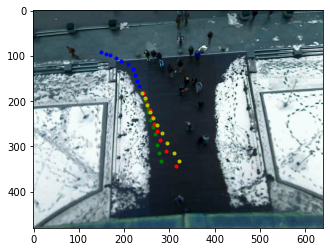

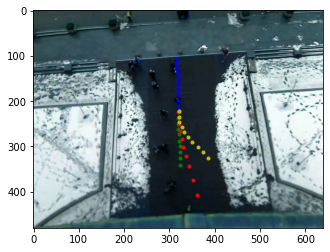

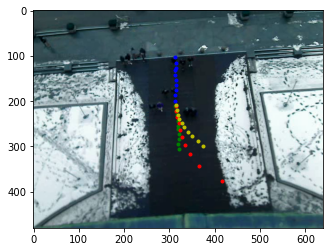

KeyboardInterrupt: 

In [51]:
test_index = list(range(0,55))
test = trainPT[test_index]
frame = testF[test_index,0,0]
test_src = torch.tensor(test[:,:seq_length//2,0:2])
test_tgt = torch.tensor(test[:,seq_length//2:,0:2])
test_src = test_src.to(torch.float32)
test_tgt = test_tgt.to(torch.float32)

output = SiameseTransformer.subnet.greedy_decode(test_src,src_mask = generate_mask(10),max_len=10)

negoutput = basemodel.greedy_decode(test_src,src_mask = generate_mask(10),max_len=10)
print("The ADE on test set is:", ADE(output[:,:,0:2], test_tgt[:,:,0:2]))
print("The FDE on test set is:", ADE(output[:,-1:,0:2], test_tgt[:,-1:,0:2]))

test_src = test_src.numpy()
test_tgt = test_tgt.numpy()
output = output.detach().numpy()
negoutput = negoutput.detach().numpy()


import os
os.environ['KMP_DUPLICATE_LIB_OK']= 'True'

import cv2
from matplotlib import pyplot as plt

converter = coordConverter("../dataset/ewap_dataset/seq_eth/H.txt")

for ins in range(0,len(test_src)):
    count = 1
    vidcap = cv2.VideoCapture("../dataset/ewap_dataset/seq_eth/seq_eth.avi")
    while count <= frame[ins]:
        s, image = vidcap.read()
        if count == frame[ins]:
            plt.imshow(image)
            for i in test_src[ins]:
                x,y = converter.meter2pix(i[0], i[1])
                plt.plot(y,x, "ob", markersize=3)
            for i in test_tgt[ins]:
                x,y = converter.meter2pix(i[0], i[1])
                plt.plot(y,x, "og", markersize=3)
            for i in output[ins]:
                x,y = converter.meter2pix(i[0], i[1])
                plt.plot(y,x, "or", markersize=3)
            for i in negoutput[ins]:
                x,y = converter.meter2pix(i[0], i[1])
                plt.plot(y,x, "oy", markersize=3)
            plt.show()
        count += 1